## Winter 2022 Data Science Internship Challenge

#### Author: Yu Wang

### Question 1

On Shopify, we have exactly 100 sneaker shops, and each of these shops sells only one
model of shoe. We want to do some analysis of the average order value (AOV). When
we look at orders data over a 30 day window, we naively calculate an AOV of $3145.13.
Given that we know these shops are selling sneakers, a relatively affordable item,
something seems wrong with our analysis.

#### a. Think about what could be going wrong with our calculation. Think about a better way to evaluate this data.

The average order value is calculated by:

$$
AOV = \frac{\text{Total Revenue within 30 days}}{\text{Number of Orders within 30 days}}
$$

This metric describes the how much a customer usually spends on an indiviual order. The calcuated AOV is significantly larger than what we would expect for products like sneakers. We suspect that there might be something wrong with the analysis. 

It is possible that there is nothing wrong with the calculation and the value is simply inflated by outliers. It is also possible that there are some data integrity issues if values were not recorded properly. We will investigate these possibilities in the following sections.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
dat = pd.read_excel("data.xlsx")

In [3]:
dat.head()

,order_id,shop_id,user_id,order_amount,total_items,payment_method,created_at
0,1,53,746,224,2,cash,2017-03-13 12:36:56.190
1,2,92,925,90,1,cash,2017-03-03 17:38:51.999
2,3,44,861,144,1,cash,2017-03-14 04:23:55.595
3,4,18,935,156,1,credit_card,2017-03-26 12:43:36.649
4,5,18,883,156,1,credit_card,2017-03-01 04:35:10.773


In [4]:
dat.describe()

,order_id,shop_id,user_id,order_amount,total_items
count,5000.000000,5000.000000,5000.000000,5000.000000,5000.00000
mean,2500.500000,50.078800,849.092400,3145.128000,8.78720
std,1443.520003,29.006118,87.798982,41282.539349,116.32032
min,1.000000,1.000000,607.000000,90.000000,1.00000
25%,1250.750000,24.000000,775.000000,163.000000,1.00000
50%,2500.500000,50.000000,849.000000,284.000000,2.00000
75%,3750.250000,75.000000,925.000000,390.000000,3.00000
max,5000.000000,100.000000,999.000000,704000.000000,2000.00000


We know that the mean (average) is not a robust metric against outliers. Some orders with a that are unusually large purchases could skew the AOV significantly. This can be comfirmed by investigating the item counts for each order. From the summarized table above, we can see that the median of the order amount is 284, which is much closer to what we would expect. The standard deviations of both order amount and total items are larger. This further suggests that the average has been influenced by outliers.

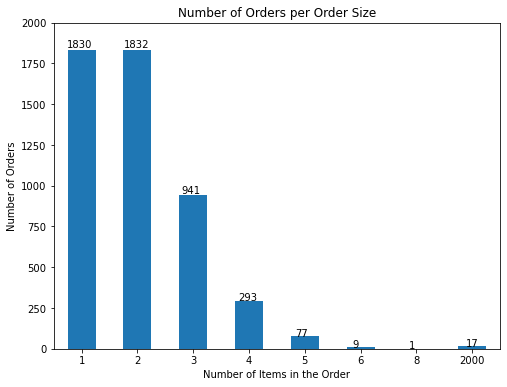

In [5]:
plt.figure(figsize=(8, 6))
plt.ylim((0, 2000))
ax = dat.total_items.value_counts().sort_index().plot.bar()
for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x() * 1.02, p.get_height() * 1.01))
plt.xticks(rotation = 0)
plt.ylabel("Number of Orders")
plt.xlabel("Number of Items in the Order")
plt.title("Number of Orders per Order Size")
plt.show()

We can see above that there are 17 orders with 2000 items purchased. This has which have skewed the AOV considerably.

We also want to know if there are any data integrity issues. Shopify is an international platform and stores may use different currencies; it is possible that the currency was not standardized and that the units were not converted to USD for some orders. This may have caused an inflation in the total revenue. 

To investigate this, I calcuated the average unit price for each store. If any store has an average value that is significantly greater, it may indicate that there are something wrong specific to the store and the currency could be a factor. 

In [6]:
dat['price_per_item'] = dat['order_amount']/dat['total_items']

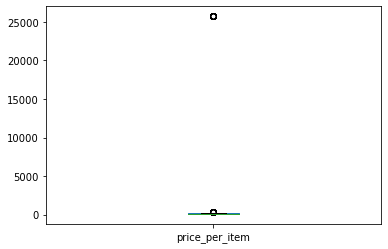

In [7]:
dat['price_per_item'].plot.box()

There are some significant outliers.

In [8]:
dat.groupby(['shop_id']).price_per_item.mean().nlargest(10)

shop_id
78    25725.0
42      352.0
12      201.0
89      196.0
99      195.0
50      193.0
38      190.0
6       187.0
51      187.0
11      184.0
Name: price_per_item, dtype: float64

In [9]:
dat[dat.shop_id == 78].head()

,order_id,shop_id,user_id,order_amount,total_items,payment_method,created_at,price_per_item
160,161,78,990,25725,1,credit_card,2017-03-12 05:56:56.834,25725.0
490,491,78,936,51450,2,debit,2017-03-26 17:08:18.911,25725.0
493,494,78,983,51450,2,cash,2017-03-16 21:39:35.400,25725.0
511,512,78,967,51450,2,cash,2017-03-09 07:23:13.640,25725.0
617,618,78,760,51450,2,cash,2017-03-18 11:18:41.848,25725.0


The store with the shop_id = 78 has a very large unit price, which warrants further investigation. Though this might just be an artifact of the simulated data, having such a large quantity being paid by cash is also very noteworthy.

There might also be some useful information in the trends of AOV. It might be helpful to look at the daily AOV. Since we already know that the data is skewed by outliers, we may also want to look at the median order values for each day. 
In the AOV plots, we can see that the inflated mean values exist on all weekdays except for Monday. The outliers have skewed the average too much, so there are no clear evidence to conclude a trend exists for the spikes. However, we can see that the median plots are not affected by the outliers and there is a trend suggesting order values are greater on weekends and lower on Wednesday. This suggests that using medians can capture the purchasing pattern without being influenced by the outliers.

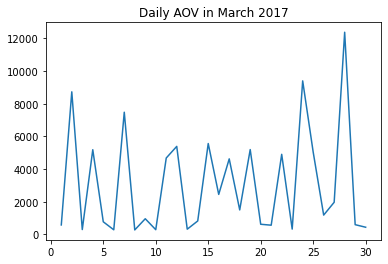

In [26]:
dat.groupby(lambda x: dat.loc[x]['created_at'].day).order_amount.mean().plot.line()
plt.title('Daily AOV in March 2017')
plt.show()

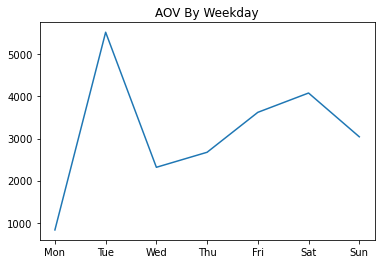

In [28]:
ax = dat.groupby(lambda x: dat.loc[x]['created_at'].weekday()).order_amount.mean().sort_index().plot.line()
plt.xticks(range(7), ["Mon", "Tue", "Wed", "Thu", "Fri", "Sat", "Sun"])
plt.title('AOV By Weekday')
plt.show()

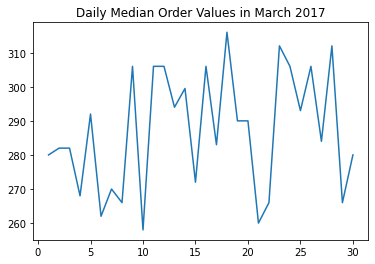

In [30]:
dat.groupby(lambda x: dat.loc[x]['created_at'].day).order_amount.median().plot.line()
plt.title('Daily Median Order Values in March 2017')
plt.show()

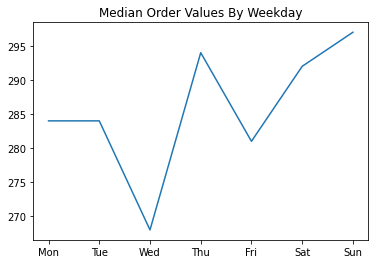

In [31]:
ax = dat.groupby(lambda x: dat.loc[x]['created_at'].weekday()).order_amount.median().sort_index().plot.line()
plt.xticks(range(7), ["Mon", "Tue", "Wed", "Thu", "Fri", "Sat", "Sun"])
plt.title('Median Order Values By Weekday')
plt.show()

#### b. What metric would you report for this dataset?

Considering the pressence of outliers in the dataset that can skew the data substantially, the median and the mode are more robust metrics compared to the mean. 

The median is the 50th percentile of the order amount across all orders. It describes the central tendency of the data is not influenced by outliers as easily. The mode is (are) the value(s) that occur(s) most frequently in the data. Though the order amounts are integers in the dataset, these amounts will be considered as continuous values in real life. Therefore, it might be more reasonable to classify the amount into groups.

The most ideal metric would also need to factor in our greatest interest. If we would like to study the "big spenders", then monitoring the 75th percentile will also be beneficial. 

#### c. What is its value?

##### Median

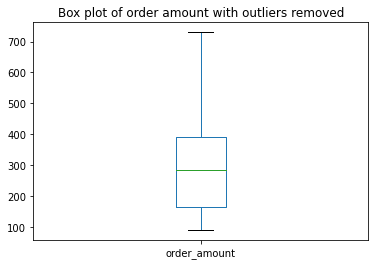

In [34]:
dat.order_amount.plot.box(showfliers=False)
plt.title("Box plot of order amount with outliers removed")
plt.show()

In [36]:
print(f" The median of the order amount is ${dat.order_amount.median()}")

The median of the order amount is $284.0


##### Mode
Since the order amount is considered continuous, and the sneaker prices could very subtly cross different stores. It is more reasonable to split the order amount into groups. Choosing an appropriate bin size will be necessary for an effective analysis in this case. The ultimate goal is to use AOV to assess the performance of the business. The number of items sold and the order amount are both valuable metrics. Therefore, we should establish bins that are large enough to tolerate the price difference across different stores and small enough to distinguish the order size. Here, I chose the standard deviation of the unit price after excluding the outliers as the bin size, which is shown in the summary table as \$28.22. For simplicity, I set the bin size to be \\$30. 

In [38]:
# Filter out the outliers
Q1, Q3 = dat['order_amount'].quantile(0.25), dat['order_amount'].quantile(0.75)
IQR = Q3 - Q1
outlier_filter = (dat['order_amount'] >= Q1 - 1.5 * IQR) & (dat['order_amount'] <= Q3 + 1.5 * IQR)

In [40]:
dat[outlier_filter].iloc[:,3:].describe()

,order_amount,total_items,price_per_item
count,4859.000000,4859.000000,4859.000000
mean,293.715374,1.950196,151.265281
std,144.453395,0.919791,28.221347
min,90.000000,1.000000,90.000000
25%,162.000000,1.000000,132.000000
50%,280.000000,2.000000,153.000000
75%,380.000000,3.000000,166.000000
max,730.000000,5.000000,352.000000


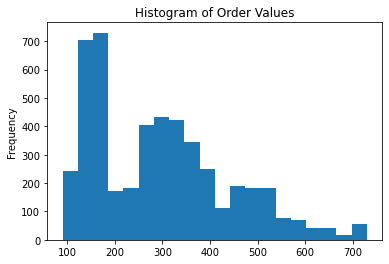

In [44]:
dat[outlier_filter].order_amount.plot.hist(bins = 20)
plt.title('Histogram of Order Values')
plt.show()

In [45]:
dat['sale_group'] = (dat.order_amount//30 + 1) * 30

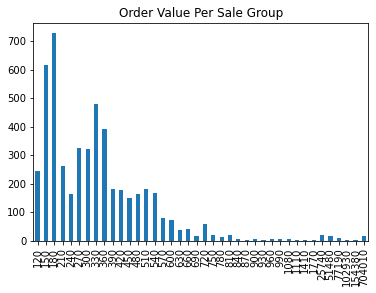

In [46]:
dat.sale_group.value_counts().sort_index().plot.bar()
plt.title('Order Value Per Sale Group')
plt.show()

In [48]:
print(f" The mode of order values is {dat.sale_group.mode()[0]}")

 The mode of order values is 180


In [51]:
print(f'''The ratio of the sales within 180 sale group against the total sales: {dat[dat.sale_group == 180].order_amount.sum()/dat[outlier_filter].order_amount.sum()} ''')

The ratio of the sales within 180 sale group against the total sales: 0.08359451583315991 


The mode estimation (\\$ 180) is quite different from the median estimation (\\$ 284). Based on the barplot above, I will consider median as a more appropriate metric. From the barplot, we can see that the mode is fairly far away from the rest of the values, so it is not a good representation of the data. Moreover, even if we filter out the outliers, this group only accounts for about 8% of the total sales. Therefore, I will choose the median of the order value $\approx \$ 284$ over the mode.

### Question 2: 

For this question you’ll need to use SQL. Follow this link to access the data set
required for the challenge. Please use queries to answer the following questions. Paste your
queries along with your final numerical answers below.


#### a. How many orders were shipped by Speedy Express in total

In [ ]:
query = '''
SELECT COUNT(*)
FROM Orders JOIN Shippers USING(ShipperID)
WHERE ShipperName = 'Speedy Express'
'''

A total of 54 orders were shipped by Speedy Express in total.

#### b. What is the last name of the employee with the most orders?

In [ ]:
query = '''
SELECT LastName, COUNT(*)
FROM Orders JOIN Employees USING(EmployeeID)
GROUP BY EmployeeID
ORDER BY 2 DESC
LIMIT 1
'''

The last name of the employee with the most orders is `Peacock`.

#### c. What product was ordered the most by customers in Germany?

In [ ]:
query = '''
WITH GermanOrder AS 
    (SELECT * FROM Orders JOIN Customers USING(CustomerID)
        WHERE Country = 'Germany'),
  MaxProduct AS
    (SELECT ProductID, SUM(Quantity) AS total
      FROM GermanOrder JOIN OrderDetails USING(OrderID)
      GROUP BY 1
      ORDER BY 2 DESC
      LIMIT 1) 
      
SELECT ProductName FROM MaxProduct JOIN Products USING(ProductID)
'''

`Boston Crab Meat` was ordered the most by customers in Germany. 